In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import exp as exp
import pandas as pd
import scipy.io as sio

# Na,K-ATPase surface approximation

In [2]:
#Array export and creating

CK = np.arange(0, 0.110001, 0.005) #23
CNa = np.arange(0, 0.50001, 0.025) #21
psi = np.arange(-80, 261, 20) #18
flux_psi = sio.loadmat('flux_psi.mat')['flux_psi']
kflux_psi = sio.loadmat('kflux_psi.mat')['kflux_psi']
naflux_psi = sio.loadmat('naflux_psi.mat')['naflux_psi']

In [3]:
def interpolate_flux(K, Na, Psi, CK=CK, CNa=CNa, psi=psi, flux_psi=flux_psi):
    def find_nearest_indices(value, array):
        idx = np.searchsorted(array, value)
        idx = np.clip(idx, 1, len(array) - 1)
        return idx - 1, idx

    def interpolate_1d(value, array, idx1, idx2):
        x1, x2 = array[idx1], array[idx2]
        return (value - x1) / (x2 - x1)

    k_idx1, k_idx2 = find_nearest_indices(K, CK)
    na_idx1, na_idx2 = find_nearest_indices(Na, CNa)
    psi_idx1, psi_idx2 = find_nearest_indices(Psi, psi)

    k_ratio = interpolate_1d(K, CK, k_idx1, k_idx2)
    na_ratio = interpolate_1d(Na, CNa, na_idx1, na_idx2)
    psi_ratio = interpolate_1d(Psi, psi, psi_idx1, psi_idx2)

    c00 = flux_psi[k_idx1, na_idx1, psi_idx1] * (1 - k_ratio) + flux_psi[k_idx2, na_idx1, psi_idx1] * k_ratio
    c01 = flux_psi[k_idx1, na_idx1, psi_idx2] * (1 - k_ratio) + flux_psi[k_idx2, na_idx1, psi_idx2] * k_ratio
    c10 = flux_psi[k_idx1, na_idx2, psi_idx1] * (1 - k_ratio) + flux_psi[k_idx2, na_idx2, psi_idx1] * k_ratio
    c11 = flux_psi[k_idx1, na_idx2, psi_idx2] * (1 - k_ratio) + flux_psi[k_idx2, na_idx2, psi_idx2] * k_ratio

    c0 = c00 * (1 - na_ratio) + c10 * na_ratio
    c1 = c01 * (1 - na_ratio) + c11 * na_ratio

    return c0 * (1 - psi_ratio) + c1 * psi_ratio

# vATPase function

In [4]:
# @jit
def J_v(pH_L, psi):
    
    psi_start, psi_end = -300, 300
    pH_start, pH_end = 0, 9
    
    if (pH_L < pH_start):
        pH_L = pH_start
    elif (pH_L > pH_end):
        pH_L = pH_end
    
    if (psi < psi_start):
        psi = psi_start
    elif (psi > psi_end):
        psi = psi_end
    
    p_a = 3.3654e-24*psi**10+-1.72718633e-21*psi**9+-1.88006118e-19*psi**8+1.84428806e-16*psi**7+1.14875767e-15*psi**6+-7.86180209e-12*psi**5+8.73621142e-11*psi**4+1.38612359e-07*psi**3+4.02706504e-06*psi**2+-0.000921991562*psi**1+0.892742811*psi**0
    p_b = -0.01183303*psi**1+-1.74410965*psi**0
    p_c = 1.97927106e-17*psi**8+-8.11163955e-15*psi**7+-1.41331765e-12*psi**6+7.37414295e-10*psi**5+2.69242151e-08*psi**4+-1.47727446e-05*psi**3+-0.0018809272*psi**2+0.0294192901*psi**1+122.27226*psi**0
    p_d = 3.32575786e-13*psi**6+-3.43339599e-11*psi**5+-5.76545216e-08*psi**4+7.89631331e-06*psi**3+0.00138326473*psi**2+0.11950506*psi**1+1.50734239*psi**0
    
    
    J = np.tanh(p_a*pH_L + p_b)*p_c-p_d
    return J


# Constants and initial value

In [5]:
init_R = 0.34                   	           #organelle radius [microns]
init_V = (4/3*3.1416*init_R**3*1e-12)/1000
init_S = 4*3.1416*init_R**2*1e-8
#{surface area [cm**2]}


CAX_Ca = 1       # Calcium stoichiometry of CAX
CAX_H = 3        # Proton stoichiometry of CAX 
CLC_Cl = 2       # Chloride stoichiometry of ClC-7
CLC_H = 1        # Proton stoichiometry of ClC-7
Ca_C = 1e-07      #[M]
Cl_C = 0.05      #[M]
Na_C = 0.015      #[M]
pH_C = 7.2     

F = 96485      #[C] Na*e
K_C = 0.145      #[M]
NA = 6.02e+23    
N_CAX = 16      #[]
N_CLC = 50      #[]
N_VATP = 550      #[]
N_NKA = 13000       #Activity of NKA


P_Ca = 1.49e-7      #[ion*cm/s]
P_Cl = 1.2e-5       #[ion*cm/s]
P_H = 6e-05      #[ion*cm/s]
P_K = 7.1e-7      #[ion*cm/s]
P_Na = 9.6e-7      #[ion*cm/s]
Pw = 0.054e-2   #water permeability
RTF = 25.69        #RT/F [mV]} 
beta_pH = 0.04      #[M/pH] Proton buffering capacity
cap = 1.45267584e-14      #[Farad] 
cap_0 = 1e-06      #[F/cm^2] Bilayer capacitance 
init_Aeff = 0.3      
init_Ca_F = 0.0006      #[M]
init_Ca_T = 0.006      #[M]
init_Cl = 0.100  #[M]
init_pH = 4.7
init_H = np.power(10, -init_pH)      #[M]
init_K = 0.060   #[M]
init_Na = 0.020   #[M]

psi_in = 0       #[mV]
psi_out = -50  
B = init_K+init_Na+init_H-init_Cl  + init_Ca_T*2 - cap/F/init_V*(psi_in - psi_out)

p = 3.88e-12      #TRPML1 coefficient 
q = 2.2
r = 0.1      #Deactivation to activation ratio 
tau_act = 1       #[s]
tau_deact = 0.25      #[s]
      


Oc = 0.291
oh =  0.73
ok =  0.73
ona = 0.73
ocl = 0.73
Q = init_V*(Oc - (oh*10**(-init_pH) + ok*init_K + ona*init_Na + ocl*init_Cl))


# Deriviatives

In [6]:
# @jit
def der_par(X, t, *par):
    '''
    compute derivatives of X wrt time
    '''
    Aeff, NH, pH, NK, NNa, NCl, NCa_T, NCa_F, R = X
    Cl_C, Ca_C, Na_C, K_C, pH_C, init_Cl, init_Ca_T, init_Na, init_K, init_pH, init_H, init_R, N_CAX, N_CLC, N_VATP, N_NKA, p, P_Cl, P_Ca, P_Na, P_K, P_H, Pw, psi_out  = par
    
    


    pure_basefication = 0
    
    V = (4/3*3.1416*abs(R)**3*1e-12)/1000
    S = 4*3.1416*abs(R)**2*1e-8


    #Luminal Concentrations
    H = NH/V/NA
    K = NK/V/NA
    Na = NNa/V/NA
    Cl = NCl/V/NA
    Ca_F = NCa_F/V/NA
    Ca_T = NCa_T/V/NA
    r = Ca_F/Ca_T


    
    #membrane potential
    psi = (F/cap)*(V*(H + K + Na - Cl + 2*Ca_T) - B*init_V)


#      Modified Cytoplasmic Surface Concentrations
    pH_C0   = (pH_C+psi_out/(RTF*2.3))
    K_C0    = K_C*exp(-psi_out/RTF)
    Na_C0   = Na_C*exp(-psi_out/RTF) 
    Cl_C0   = Cl_C*exp(psi_out/RTF) 
    Ca_F_C0 = Ca_C*exp(-2*psi_out/RTF) 
    
#     Modified Luminal Surface Concentrations
    pH_L0   = (pH+psi_in/(RTF*2.3))
    K_L0    = K*exp(-psi_in/RTF)
    Na_L0   = Na*exp(-psi_in/RTF) 
    Cl_L0   = Cl*exp(psi_in/RTF) 
    Ca_F_L0 = Ca_F*exp(-2*psi_in/RTF) 

    delta_pH    = pH_C0-pH_L0;  

#     Treatment of singular terms for passive ion flux
    if (abs(psi) > 300):
        psi = np.sign(psi)*300
    if (abs(psi) > 0.01):
        gg      =  psi / (1 - exp (- psi / RTF)) / RTF
        gg_Ca   = 2*psi/(1-exp(-2*psi/RTF))/RTF

    else: 
        gg      =  1 / 1 - (psi / RTF)/2 + (psi / RTF)**2/6 - (psi / RTF)**3 / 24 + (psi / RTF) ** 4 / 120
        gg_Ca   = 1/(1 - (psi/RTF) + (2/3)*(psi/RTF)**2 - (1/3)*(psi/RTF)**3 +(2/15)*(psi/RTF)**4)
        

    # vAPTase
    J_VATPASE  = N_VATP * J_v(pH, psi)


        # ClC-7 Antiporter {H out, Cl in}
    CLC_mu      = (CLC_H + CLC_Cl)*psi + RTF*(CLC_H*2.3*delta_pH + CLC_Cl*np.log(Cl_C0/Cl_L0))
    
    #     Switching function   
    x = 0.5 + 0.5*np.tanh((CLC_mu + 250)/75); 
    # Activity
    A = 0.3*x + 1.5E-5*(1-x)*CLC_mu**2;
    
    if (A < Aeff):
        tau = tau_deact
    else:
        tau = tau_act
        
    J_CLC    = N_CLC*Aeff*CLC_mu 
    
    
#      CAX Antiporter {H out, Ca in} [mV, ion/s]
    CAX_mu = (CAX_H - 2*CAX_Ca)*psi + RTF*(CAX_H*2.3*delta_pH + CAX_Ca/2*np.log(Ca_F_L0/Ca_F_C0))
    J_CAX = N_CAX*CAX_mu
    
    
    
    
#      Passive flux [ion/s]
    J_H = P_H*S*(10**(-pH_C0)*exp(-psi/RTF)-10**(-pH_L0))*gg*NA/1000
    J_K = P_K*S*(K_C0*exp(-psi/RTF)-K_L0)*gg*NA/1000
    J_Na = P_Na*S*(Na_C0*exp(-psi/RTF)-Na_L0)*gg*NA/1000


    J_Cl_unc = P_Cl*S*(Cl_C0-Cl_L0*exp(-psi/RTF))*gg*NA/1000
    J_Ca = P_Ca*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000
    


    
    #water flux
    J_w = Pw*S*(oh*10**(-pH) + ok*K + ona*Na + ocl*Cl + Q/V - Oc)
    
#     TRPML1 channel
    y = 0.5 - 0.5*np.tanh(psi + 40)
    P_trpml1 = p*(y*abs(psi) + (1-y)*(abs (psi + 40)**3)/(pH_L0**q))
    J_Ca_trpml1 = P_trpml1*S*(Ca_F_C0*exp(-2*psi/RTF)-Ca_F_L0)*gg_Ca*NA/1000

    J_vNa = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = naflux_psi)
    J_vK = interpolate_flux(K=K, Na = Na, Psi = psi, flux_psi = kflux_psi)


    
    dxdt = [(1/tau)*(A - Aeff),
        J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication, 
           (-(J_H + (J_VATPASE) - (CLC_H*J_CLC) - (CAX_H*J_CAX) - pure_basefication)/V/NA)/beta_pH,
           J_K + N_NKA*J_vK,
           J_Na + N_NKA*J_vNa,
           J_Cl_unc + (CLC_Cl*J_CLC),
           J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1,
           (J_Ca + (CAX_Ca*J_CAX) + J_Ca_trpml1)*r, 
           J_w/(1000*55)/(4*np.pi*(R/1e5)**2)*1e5]

    return dxdt

In [7]:
def psi_stat_def(solution, V_arr, init_V):
    psi_stat = (F/cap)*(V_arr*(solution[:, 1][-1]/V_arr/NA + solution[:, 3][-1]/V_arr/NA + solution[:, 4][-1]/V_arr/NA - solution[:, 5][-1]/V_arr/NA + 2*solution[:, 6][-1]/V_arr/NA) - B*init_V)
    return psi_stat
def V_stat_def(solution):
    V_stat = (4/3*3.1416*solution[:, 8][-1]**3*1e-12)/1000
    return V_stat

In [8]:
def solver(parameters):
    Cl_C, Ca_C, Na_C, K_C, pH_C, init_Cl, init_Ca_T, init_Na, init_K, init_pH, init_H, init_R, N_CAX, N_CLC, N_VATP, N_NKA, p, P_Cl, P_Ca, P_Na, P_K, P_H, Pw, psi_out = parameters
    init_NH = init_H*init_V*NA;      #[ions]
    init_NK = init_K*init_V*NA;       
    init_NNa = init_Na*init_V*NA;    
    init_NCl = init_Cl*init_V*NA;     
    init_NCa_T = init_Ca_T*init_V*NA; 
    init_NCa_F = init_Ca_F*init_V*NA; 

    X0 = [init_Aeff, init_NH, init_pH, init_NK, init_NNa, init_NCl, init_NCa_T, init_NCa_F, init_R]

    tspan = np.arange(0, 1200, 1e-2)
    solution = odeint(der_par, X0, tspan, args=tuple(parameters))

    init_V_n = (4/3*3.1416*init_R**3*1e-12)/1000
    V_stat = V_stat_def(solution)
    psi_stat = psi_stat_def(solution, V_stat, init_V_n)
    
    
    return np.array([solution[:, 1][-1]/V_stat/NA, solution[:, 2][-1], solution[:, 3][-1]/V_stat/NA, solution[:, 4][-1], solution[:, 5][-1]/V_stat/NA, solution[:, 7][-1]/V_stat/NA, solution[:, 8][-1], psi_stat])
    


In [9]:
pars_defoult = np.array([Cl_C, Ca_C, Na_C, K_C, pH_C, init_Cl, init_Ca_T, init_Na, init_K, init_pH, init_H, init_R, N_CAX, N_CLC, N_VATP, N_NKA, p, P_Cl, P_Ca, P_Na, P_K, P_H, Pw, psi_out ])

In [10]:
defoult_sol = solver(pars_defoult)

In [11]:
names = [r'$[H^+]$', 'pH', r'$[K^+]$', r'$[Na^+]$', r'$[Cl^-]$', r'$[Ca^{2+}]$', 'R', r'$\Delta\psi$']

names_par = [r'$[Cl^-]_{C0}$', r'$[Ca^{2+}]_{C0}$', r'$[Na^+]_{C0}$', r'$[K^+]_{C0}$', r'$pH_{C0}$',
              r'$[Cl^-]_{L0}$', r'$[Ca^{2+}]_{L0}$', r'$[Na^+]_{L0}$', r'$[K^+]_{L0}$', r'$pH_{L0}$', r'$[H^+]_{L0}$',
              r'$R_0$', r'$N_{CAX}$', r'$N_{CLC}$', r'$N_{VATP}$', r'$N_{NKA}$', r'$p_{trpml}$',
                r'$P_{Cl}$', r'$P_{Ca}$', r'$P_{Na}$', r'$P_K$', r'$P_H$', r'$P_{water}$', r'$\psi_{out}-\psi_{in}$']

In [12]:
df_plus = pd.DataFrame(columns=names_par, index=names)
df_minus = pd.DataFrame(columns=names_par, index=names)

In [13]:
for i, changed_par in enumerate(names_par):
    pars_plus = np.copy(pars_defoult)
    pars_minus = np.copy(pars_defoult)
    pars_plus[i] = pars_plus[i]*1.1
    pars_minus[i] = pars_minus[i]*0.9
    sol_plus = solver(pars_plus)
    sol_minus = solver(pars_minus)
    df_plus[changed_par] = (sol_plus - defoult_sol)/defoult_sol*100
    df_minus[changed_par] = (sol_minus - defoult_sol)/defoult_sol*100
    
    

In [14]:
import seaborn as sns

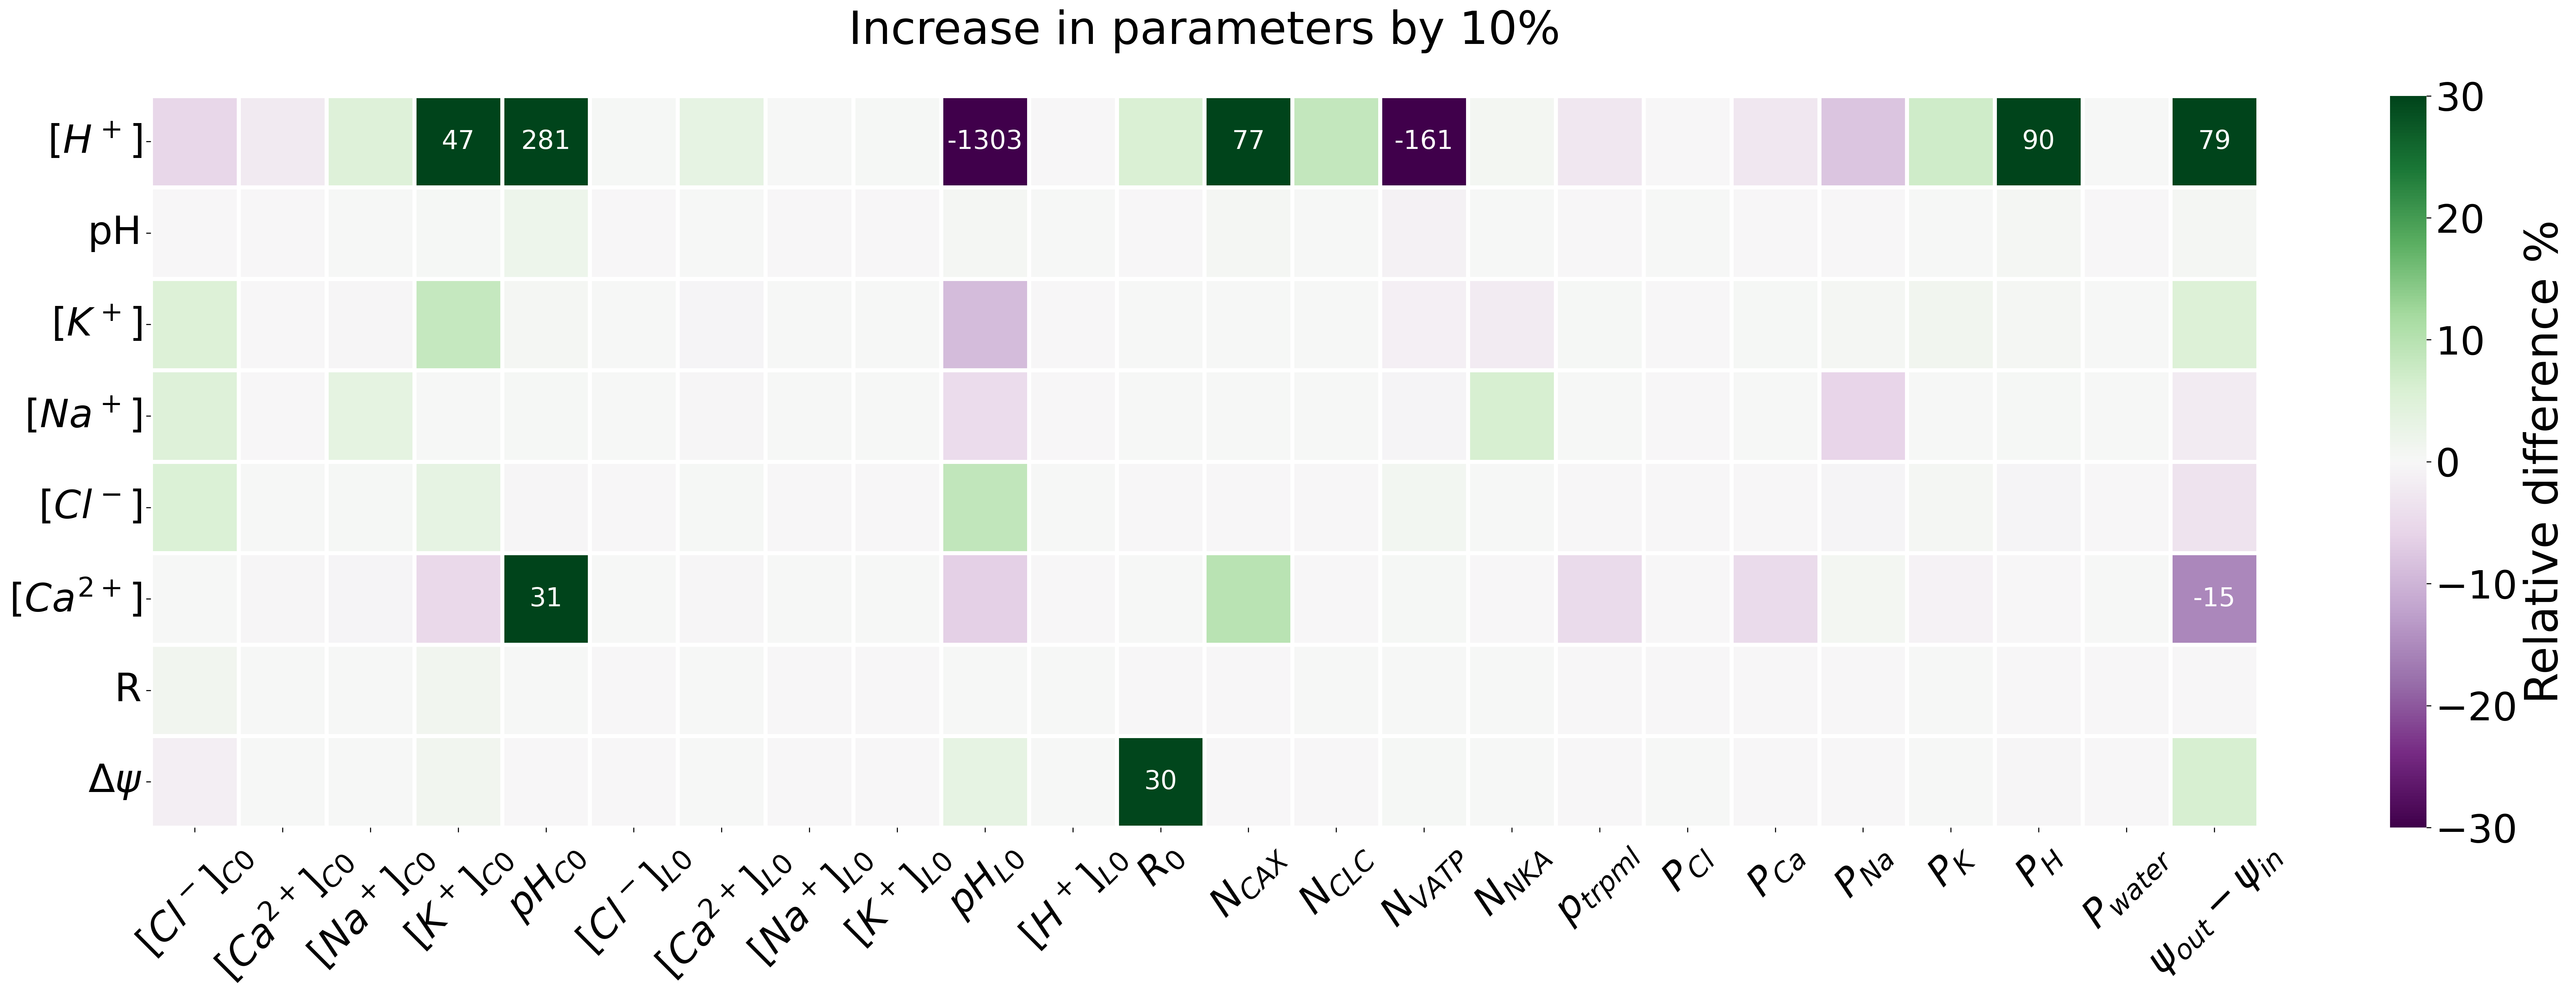

In [15]:
plt.figure(figsize = (30, 10), dpi = 300)
ax = sns.heatmap(data = df_plus, vmin = -30, vmax = 30, cmap='PRGn', linewidths=3, linecolor='white', annot=True, annot_kws={"size":20}, xticklabels=names_par, fmt='g')
plt.xticks(fontsize = 30, rotation = 45)
plt.yticks(fontsize = 30, rotation = 0)
ax.figure.axes[-1].set_ylabel('Relative difference %', size=35)
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=30)

for t in ax.texts:
    if (abs(round(float(t.get_text())))>10):
        t.set_text(round(float(t.get_text())))
    else:
        t.set_text("") 

plt.tight_layout()
plt.title('Increase in parameters by 10%', fontsize = 35, pad=40)
plt.savefig('figs/state_plus', dpi = 300)
plt.show()

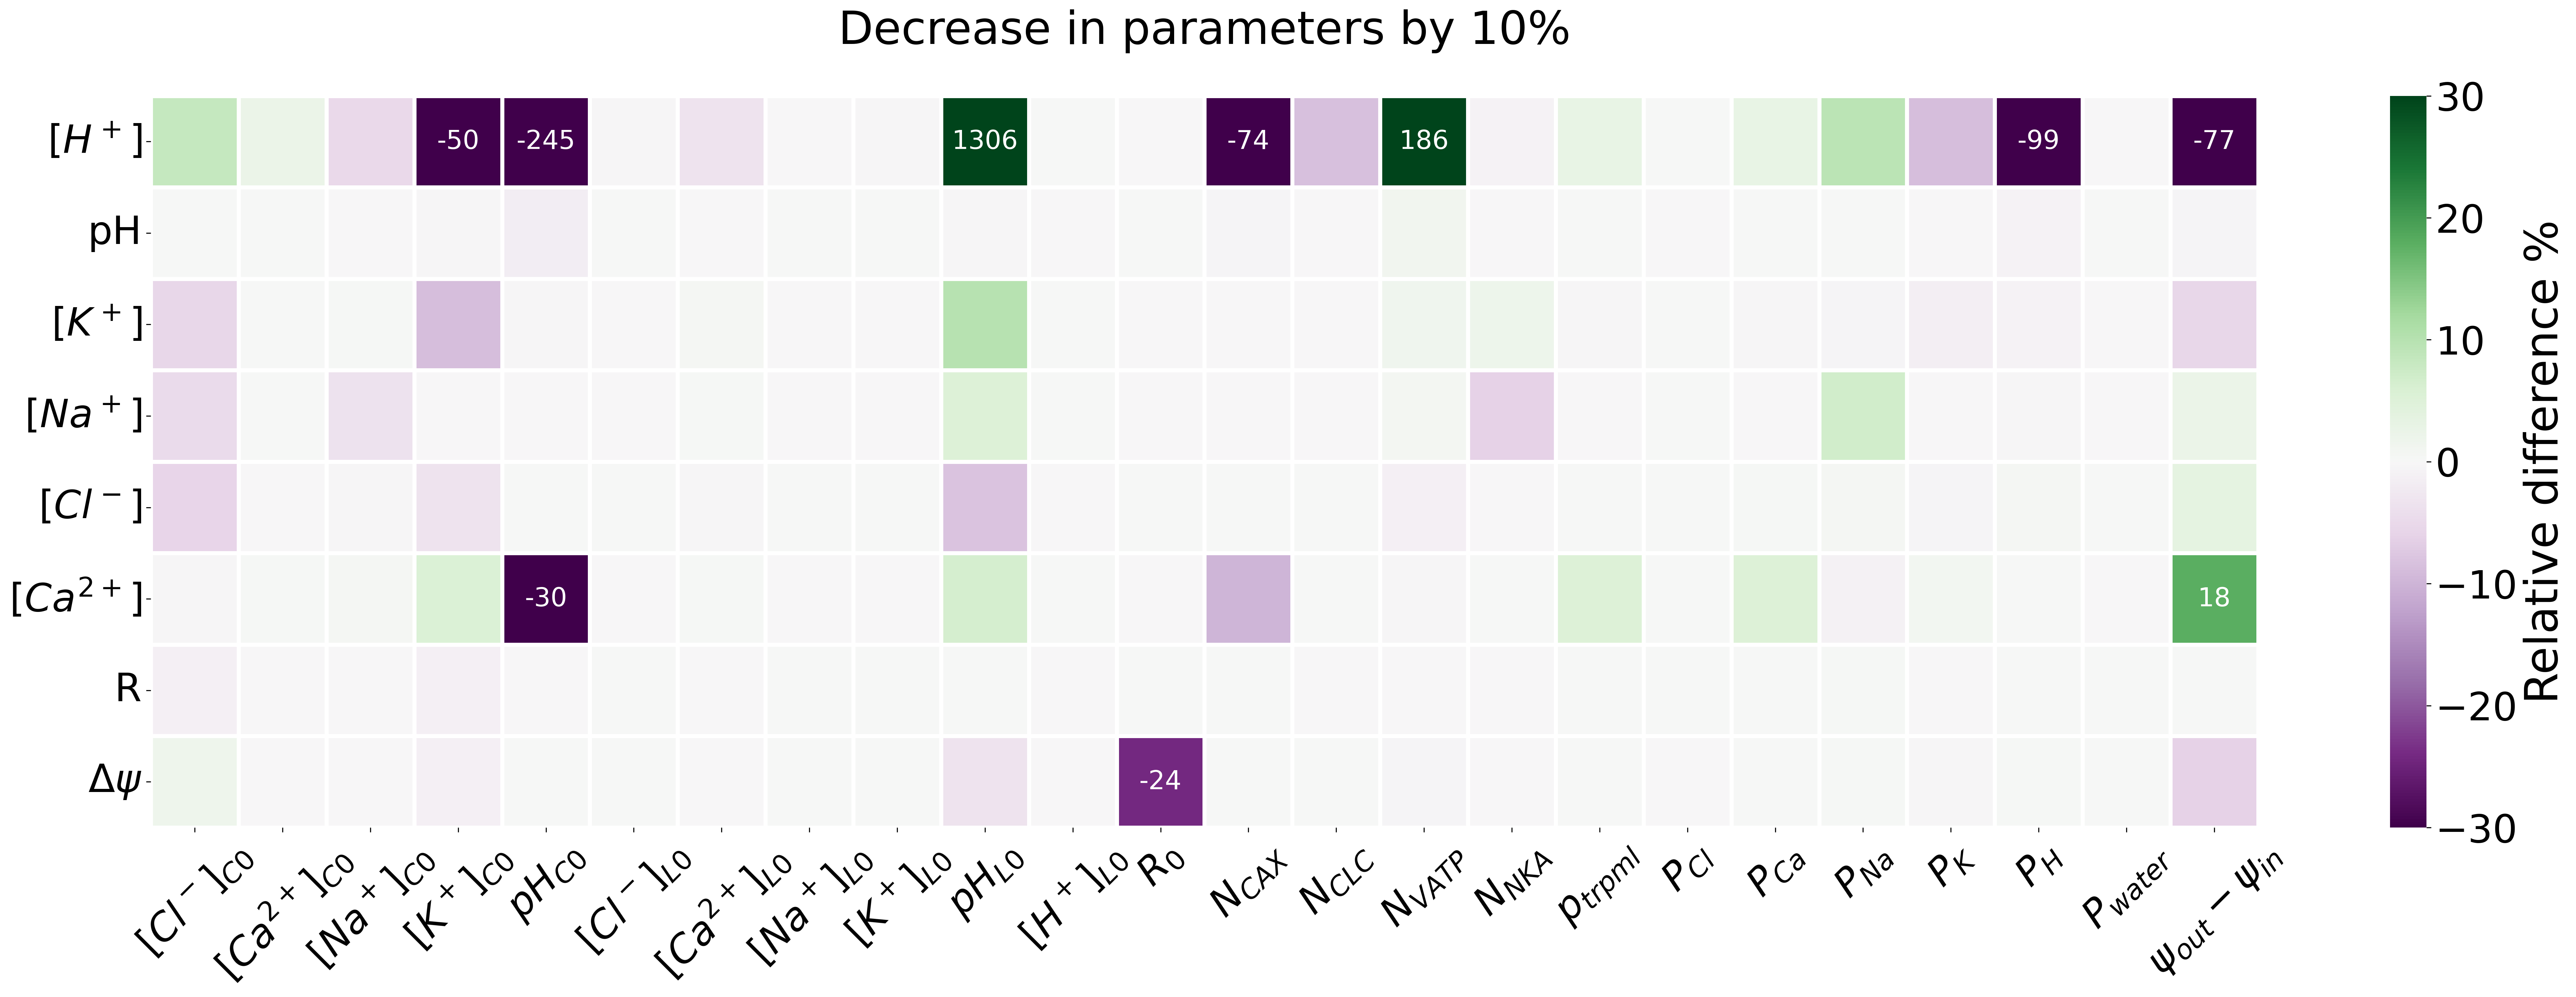

In [16]:
plt.figure(figsize = (30, 10), dpi = 300)
ax = sns.heatmap(data = df_minus, vmin = -30, vmax = 30, cmap='PRGn', linewidths=3, linecolor='white', annot=True, annot_kws={"size":20}, fmt='g')
plt.xticks(fontsize = 30, rotation = 45)
plt.yticks(fontsize = 30, rotation = 0)
ax.figure.axes[-1].set_ylabel('Relative difference %', size=35)
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=30)

for t in ax.texts:
    if (abs(round(float(t.get_text())))>10):
        t.set_text(round(float(t.get_text())))
    else:
        t.set_text("") 

plt.tight_layout()
plt.title('Decrease in parameters by 10%', fontsize = 35, pad = 40)
plt.savefig('figs/state_minus', dpi = 300)


plt.show()